In [252]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib notebook
%matplotlib inline

np.set_printoptions(precision=15)
mp.dps = 100


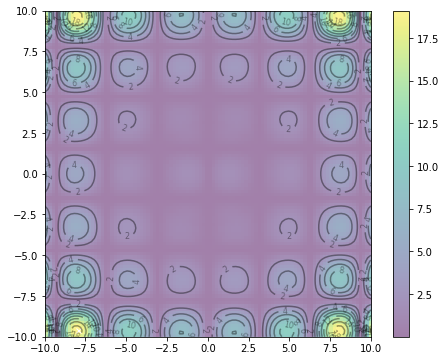

In [253]:
def f(x, y):
	"Objective function"
	"bounds: [-10, 10]"
	return np.abs(np.sin(x) * np.cos(y) * np.exp(np.abs(1 - (np.sqrt(np.power(x, 2) + np.power(y, 2))/np.pi))))


f_bounds = (-10, 10)
f_type = 'max'

x, y = np.array(np.meshgrid(np.linspace(
	f_bounds[0], f_bounds[1], 100), np.linspace(f_bounds[0], f_bounds[1], 100)))
z = f(x, y)
x_max = x.ravel()[z.argmax()]
y_max = y.ravel()[z.argmax()]
plt.figure(figsize=(8, 6))
plt.imshow(z, extent=[f_bounds[0], f_bounds[1], f_bounds[0], f_bounds[1]],
           origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_max], [y_max], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()


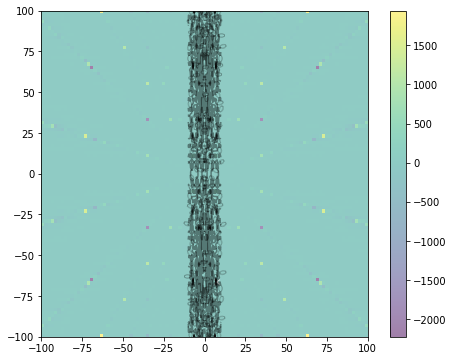

In [254]:
def g(X, Y):
	"Objective function"
	"bounds: [-100, 100]"
	
	if len(X.shape) > 1:
		return X * np.sin(np.pi * np.cos(X) * np.tan(Y)) * (np.sin(Y / X) / (1 + np.cos(Y / X)))
	
	result = []
	for x, y in zip(X, Y):
		r = x * mp.sin(mp.pi * mp.cos(x) * mp.tan(y)) * (mp.sin(mp.mpf(y) / mp.mpf(x)) / (1 + mp.cos(mp.mpf(y) / mp.mpf(x))))
		result.append(r)

	result = np.array(result)
	return result


g_bounds = (-100, 100)
g_type = 'min'


x, y = np.array(np.meshgrid(np.linspace(f_bounds[0], f_bounds[1], 100), np.linspace(g_bounds[0], g_bounds[1], 100)))
z = g(x, y)
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
plt.figure(figsize=(8, 6))
plt.imshow(z, extent=[g_bounds[0], g_bounds[1], g_bounds[0], g_bounds[1]], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()


In [255]:
def initial(objective_function, bounds, n_particles, type_):
	X = np.random.rand(2, n_particles) * \
            np.sum(np.abs(bounds)) - np.abs(bounds[0])
	V = np.random.rand(2, n_particles) * 0.1

	pbest = X
	pbest_obj = objective_function(X[0], X[1])
	if type_ == 'max':
		gbest = pbest[:, pbest_obj.argmax()]
		gbest_obj = pbest_obj.max()
	else:
		gbest = pbest[:, pbest_obj.argmin()]
		gbest_obj = pbest_obj.min()

	return X, V, pbest, pbest_obj, gbest, gbest_obj


In [256]:
def initiate_figure(objective_function, bounds, type_, X, V, pbest, gbest):
	
	x, y = np.array(np.meshgrid(np.linspace(
		bounds[0], bounds[1], 100), np.linspace(bounds[0], bounds[1], 100)))

	z = objective_function(x, y)

	# Find the global optimum
	if type_ == 'max':
		x_opt = x.ravel()[z.argmax()]
		y_opt = y.ravel()[z.argmax()]
	else:
		x_opt = x.ravel()[z.argmin()]
		y_opt = y.ravel()[z.argmin()]

	# Set up base figure: The contour map
	fig, ax = plt.subplots(figsize=(8, 6))
	fig.set_tight_layout(True)
	img = ax.imshow(z, extent=[f_bounds[0], f_bounds[1], f_bounds[0], f_bounds[1]],
                 origin='lower', cmap='viridis', alpha=0.5)
	fig.colorbar(img, ax=ax)
	ax.plot([x_opt], [y_opt], marker='x', markersize=5, color="white")
	contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
	ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
	pbest_plot = ax.scatter(
		pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
	p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
	p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue',
                     width=0.005, angles='xy', scale_units='xy', scale=1)
	gbest_plot = plt.scatter([gbest[0]], [gbest[1]],
                          marker='*', s=100, color='black', alpha=0.4)
	ax.set_xlim(list(bounds))
	ax.set_ylim(list(bounds))

	return fig, ax, pbest_plot, p_plot, p_arrow, gbest_plot


In [257]:
def update(objective_function, c1, c2, w, type_, X, V, pbest, pbest_obj, gbest, gbest_obj):
	
	r = np.random.rand(2)
	V = w * V + c1 * r[0] * (pbest - X) + c2 * r[1] * (gbest.reshape(-1, 1) - X)
	X = X + V
	obj = objective_function(X[0], X[1])
	
	if type_ == 'max':
		pbest[:, (pbest_obj <= obj)] = X[:, (pbest_obj <= obj)]
		pbest_obj = np.array([pbest_obj, obj]).max(axis=0)
		gbest = pbest[:, pbest_obj.argmax()]
		gbest_obj = pbest_obj.max()
	else:
		pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
		pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
		gbest = pbest[:, pbest_obj.argmin()]
		gbest_obj = pbest_obj.min()
	
	return X, V, pbest, pbest_obj, gbest, gbest_obj


In [258]:
def PSO(objective_function, bounds, type_, c1, c2, w, intervals=500, name='PSO.gif'):
	X, V, pbest, pbest_obj, gbest, gbest_obj = initial(
		objective_function, bounds, n_particles, type_)

	fig, ax, pbest_plot, p_plot, p_arrow, gbest_plot = initiate_figure(objective_function,
		bounds, type_, X, V, pbest, gbest)

	def animate(i):
		"Steps of PSO: algorithm update and show in plot"
		nonlocal V, X, pbest, pbest_obj, gbest, gbest_obj

		# Update params
		X, V, pbest, pbest_obj, gbest, gbest_obj = update(
			objective_function, c1, c2, w, type_, X, V, pbest, pbest_obj, gbest, gbest_obj)

		print(i, gbest, gbest_obj)

		title = 'Iteration {:02d}'.format(i)
		# Set picture
		ax.set_title(title)
		pbest_plot.set_offsets(pbest.T)
		p_plot.set_offsets(X.T)
		p_arrow.set_offsets(X.T)
		p_arrow.set_UVC(V[0], V[1])
		gbest_plot.set_offsets(gbest.reshape(1, -1))
		return ax, pbest_plot, p_plot, p_arrow, gbest_plot

	anim = FuncAnimation(fig, animate, frames=list(
		range(1, intervals)), interval=intervals, blit=False, repeat=True)
	writergif = PillowWriter(fps=30)
	anim.save(name, writer=writergif)
	plt.close(fig)


In [262]:
n_particles = 20

c1 = 0.1
c2 = 0.1
w = 0.8


intervals = 100

name = 'PSO_f.gif'

PSO(f, f_bounds, f_type, c1, c2, w, intervals, name)


1 [-8.151563946368736 -9.021113941712805] 15.509138869018257
1 [-8.151563946368736 -9.021113941712805] 15.509138869018257
2 [-8.151563946368736 -9.021113941712805] 15.509138869018257
3 [-8.151563946368736 -9.021113941712805] 15.509138869018257
4 [-8.151563946368736 -9.021113941712805] 15.509138869018257
5 [-8.151563946368736 -9.021113941712805] 15.509138869018257
6 [-8.151563946368736 -9.021113941712805] 15.509138869018257
7 [-8.151563946368736 -9.021113941712805] 15.509138869018257
8 [-8.151563946368736 -9.021113941712805] 15.509138869018257
9 [-8.151563946368736 -9.021113941712805] 15.509138869018257
10 [-8.161785494643384 -9.028085027185835] 15.564832050964677
11 [-8.18726382120575  -9.045461219852903] 15.692760861624535
12 [-8.220000312445274 -9.194419757950978] 16.953023466952608
13 [-8.220000312445274 -9.194419757950978] 16.953023466952608
14 [-8.220000312445274 -9.194419757950978] 16.953023466952608
15 [-8.344735499817505 -9.285891293087188] 17.093033568934118
16 [-8.34473549981

![pso_f](./PSO_f.gif?id=4)

In [260]:
n_particles = 20

c1 = 0.3
c2 = 0.1
w = 0.7


intervals = 1000

name = 'PSO_g.gif'

PSO(g, g_bounds, g_type, c1, c2, w, intervals, name)


1 [-32.41667637194794  93.71334974759722] -216.9615880635592979703841609579735820040002169103955405796186357420130556505169782408019232136601451
1 [-32.41667637194794  93.71334974759722] -216.9615880635592979703841609579735820040002169103955405796186357420130556505169782408019232136601451
2 [-32.41667637194794  93.71334974759722] -216.9615880635592979703841609579735820040002169103955405796186357420130556505169782408019232136601451
3 [-32.41667637194794  93.71334974759722] -216.9615880635592979703841609579735820040002169103955405796186357420130556505169782408019232136601451
4 [-31.00242537657715  90.80178763792235] -228.1366806972300735595228769855367830149709430493183911380264562406133416095664083114593019766341656
5 [-31.00242537657715  90.80178763792235] -228.1366806972300735595228769855367830149709430493183911380264562406133416095664083114593019766341656
6 [-24.89368805715396  82.30782650336215] -242.16905256764009997115380662160842534461552078989855915917708015361876587275833818559

![pso_g](./PSO_g.gif?id=3)